# Illustrates the use of the WR (Weather Regime) class

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
import sys
sys.path.insert(0, '../')

In [3]:
from paleopy import proxy
from paleopy import analogs
from paleopy import ensemble

In [4]:
djsons = '../jsons/'
pjsons = '../jsons/proxies'

### instantiates a proxy with the required parameters

In [5]:
p = proxy(sitename='Rarotonga', \
          lon = -159.82, \
          lat = -21.23, \
          djsons = djsons, \
          pjsons = pjsons, \
          pfname = 'Rarotonga.json', \
          dataset = 'ersst', \
          variable ='sst', \
          measurement ='delta O18', \
          dating_convention = 'absolute', \
          calendar = 'gregorian',\
          chronology = 'historic', \
          season = 'DJF', \
          value = 0.6, \
          calc_anoms = True, \
          detrend = True)

### go throught the necessary steps to get to the analog seasons

In [6]:
p.extract_ts()
p.calculate_season()
p.find_analogs()

### print the updated proxy features

In [7]:
p.proxy_repr(pprint=True)

{
sitename:Rarotonga
proxy_type:None
measurement:delta O18
dating_convention:absolute
calendar:gregorian
chronology:historic
coords:(200.18, -21.23)
aspect:None
elevation:None
season:DJF
dataset:ersst
variable:sst
calc_anoms:True
detrend:True
value:0.6
climatology:(1981, 2010)
period:(1979, 2014)
extracted_coords:[200.0, -22.0]
distance_point:87.56368858840081
trend_params:{'intercept': -60.96501637775517, 'slope': 0.030535947029886681}
category:WA
analog_years:[1982, 1997, 1999, 2000, 2001, 2006, 2009]
}


### Now instantiates a `WR` class, passing the proxy object

In [8]:
from paleopy import WR

#### WR frequency changes associated with the analog years for Kidson types: classifation = `New Zealand`

In [9]:
w = WR(p, classification='New Zealand')

#### plots the bar plot, significance level = 99%

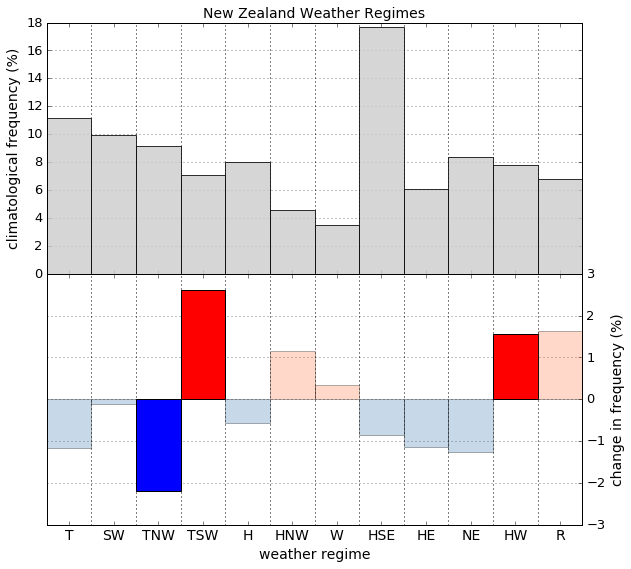

In [10]:
f = w.plot_bar(sig=1)

#### WR frequency changes associated with the analog years for the SW Pacific regimes  = `SW Pacific`

In [11]:
w = WR(p, classification='SW Pacific')

#### plots the bar plot, significance level = 99%

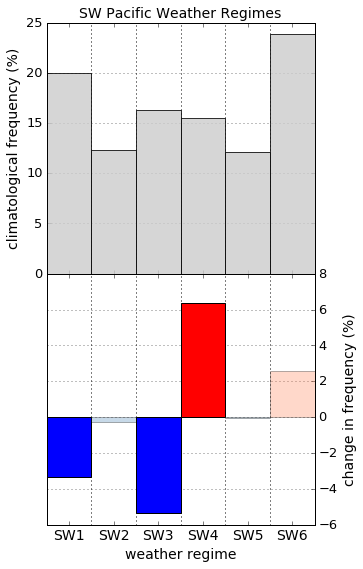

In [12]:
f = w.plot_bar(sig=1)

### now passing an `ensemble` object 

In [13]:
ens = ensemble(djsons=djsons, pjsons=pjsons, season='DJF')

In [14]:
classification = 'New Zealand'

In [15]:
w = WR(ens, classification=classification)

In [16]:
w.parent.description

'ensemble'

In [17]:
w.climatology

[1981, 2010]

In [18]:
w.probs_anomalies(kind='many')

In [19]:
w.df_anoms

,Amedee,Avoca,Browning Creek,Cameron,Caples,Cass,Clarke,Crow,Falls Creek,Frances,...,Jollie,Mistake,Oroko,Pear Drop,Pyke,Rarotonga,Taramakau,Temple,Turnbull,Washington Isl.
T,-0.034153,0.029260,-0.011879,0.029260,0.006921,0.022931,-0.011879,0.022931,0.006921,0.006921,...,0.022931,0.006921,0.022931,-0.011879,0.006921,-0.011721,0.029260,-0.011879,-0.011879,-0.026255
SW,-0.014064,0.020881,0.009805,0.020881,0.025431,0.027210,0.009805,0.027210,0.025431,0.025431,...,0.027210,0.025431,0.027210,0.009805,0.025431,-0.001115,0.020881,0.009805,0.009805,-0.029862
TNW,0.009492,0.006487,0.009651,0.006487,0.018970,0.006487,0.009651,0.006487,0.018970,0.018970,...,0.006487,0.018970,0.006487,0.009651,0.018970,-0.021884,0.006487,0.009651,0.009651,0.017390
TSW,-0.005787,-0.019925,-0.002520,-0.019925,0.003692,-0.021507,-0.002520,-0.021507,0.003692,0.003692,...,-0.021507,0.003692,-0.021507,-0.002520,0.003692,0.026114,-0.019925,-0.002520,-0.002520,0.030548
H,0.028842,0.010027,0.011610,0.010027,-0.005913,0.005280,0.011610,0.005280,-0.005913,-0.005913,...,0.005280,-0.005913,0.005280,0.011610,-0.005913,-0.005678,0.010027,0.011610,0.011610,-0.043828
HNW,-0.001204,-0.009045,-0.001134,-0.009045,-0.002784,-0.005881,-0.001134,-0.005881,-0.002784,-0.002784,...,-0.005881,-0.002784,-0.005881,-0.001134,-0.002784,0.011615,-0.009045,-0.001134,-0.001134,-0.009103
W,0.004770,0.003250,0.004832,0.003250,0.000030,0.009579,0.004832,0.009579,0.000030,0.000030,...,0.009579,0.000030,0.009579,0.004832,0.000030,0.003310,0.003250,0.004832,0.004832,-0.004709
HSE,0.000356,-0.038921,-0.023098,-0.038921,-0.043878,-0.035756,-0.023098,-0.035756,-0.043878,-0.043878,...,-0.035756,-0.043878,-0.035756,-0.023098,-0.043878,-0.008592,-0.038921,-0.023098,-0.023098,0.043010
HE,-0.005291,-0.009951,-0.009951,-0.009951,-0.010031,-0.013115,-0.009951,-0.013115,-0.010031,-0.010031,...,-0.013115,-0.010031,-0.013115,-0.009951,-0.010031,-0.011455,-0.009951,-0.009951,-0.009951,-0.006871
NE,0.004611,0.014245,0.006333,0.014245,0.004611,0.006333,0.006333,0.006333,0.004611,0.004611,...,0.006333,0.004611,0.006333,0.006333,0.004611,-0.012541,0.014245,0.006333,0.006333,0.015669


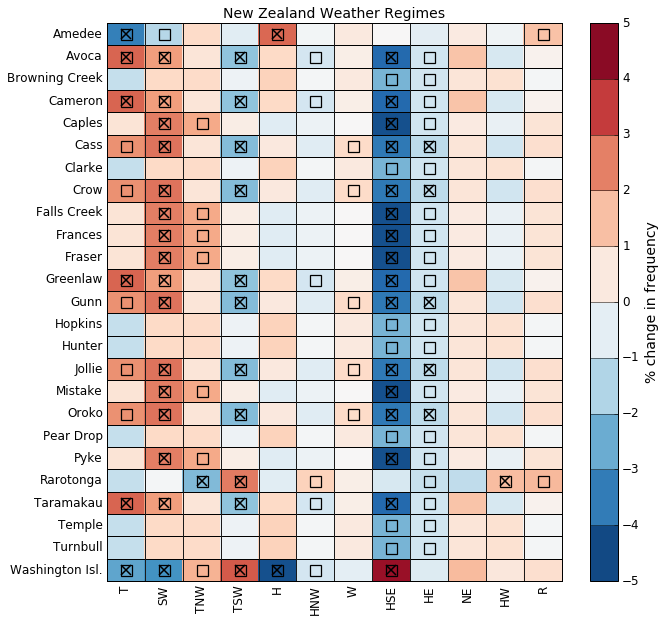

In [20]:
f = w.plot_heatmap()

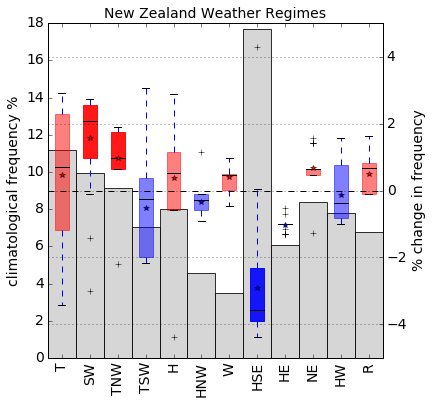

In [21]:
f = w.plot_bar()